## Carte de vulnérabilité du COVID-19 en Afrique du Sud par Nimba Hub 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
## importation des données
train = pd.read_csv('Train_maskedv2.csv')
test = pd.read_csv('Test_maskedv2.csv')
samplesubmissionv2 = pd.read_csv('samplesubmissionv2.csv')
variable_descriptions = pd.read_csv('variable_descriptions_v2.csv')

In [4]:
train.shape, test.shape

((3174, 50), (1102, 49))

In [5]:
#train.head(5)

In [6]:
variable_descriptions

,Column,Description
0,total_households,Totoal number of households in ward
1,total_individuals,Total number of individuals in ward
2,target_pct_vunerable,Percentage of large households who have to lea...
3,dw_00,Percentage of dwellings of type: House or bric...
4,dw_01,Percentage of dwellings of type: Traditional d...
5,dw_02,Percentage of dwellings of type: Flat or apart...
6,dw_03,Percentage of dwellings of type: Cluster house...
7,dw_04,Percentage of dwellings of type: Townhouse (se...
8,dw_05,Percentage of dwellings of type: Semi-detached...
9,dw_06,Percentage of dwellings of type: House/flat/ro...


In [7]:
## les données manquantes
train.isna().sum()
## les duplications
train.duplicated().sum()

0

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3174 entries, 0 to 3173
Data columns (total 50 columns):
ward                    3174 non-null object
total_households        3174 non-null float64
total_individuals       3174 non-null float64
target_pct_vunerable    3174 non-null float64
dw_00                   3174 non-null float64
dw_01                   3174 non-null float64
dw_02                   3174 non-null float64
dw_03                   3174 non-null float64
dw_04                   3174 non-null float64
dw_05                   3174 non-null float64
dw_06                   3174 non-null float64
dw_07                   3174 non-null float64
dw_08                   3174 non-null float64
dw_09                   3174 non-null float64
dw_10                   3174 non-null float64
dw_11                   3174 non-null float64
dw_12                   3174 non-null int64
dw_13                   3174 non-null int64
psa_00                  3174 non-null float64
psa_01                  

# Feature Engineering

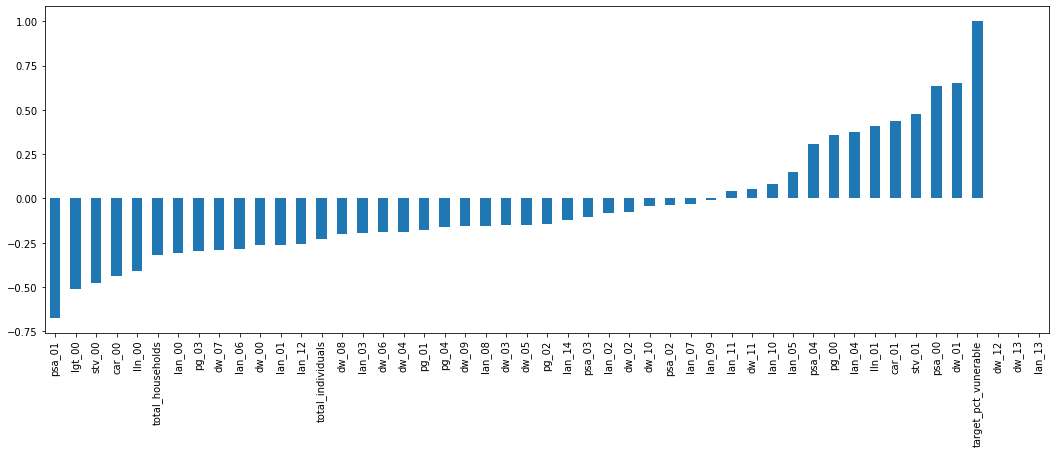

In [9]:
# Corrélation des variables
train.corr()['target_pct_vunerable'].sort_values().plot(kind='bar', figsize=(18, 6))

In [10]:
train['dw_12'].nunique(), train['dw_13'].nunique(), train['lan_13'].nunique(), train['lan_09'].nunique()

(1, 1, 1, 2831)

In [11]:
# suppression des variables qui sont pas corrolé avec notre variable d'étude
train= train.drop(['dw_12', 'dw_13', 'lan_13', 'lan_09'], axis=1)
test= test.drop(['dw_12', 'dw_13', 'lan_13', 'lan_09'],axis=1)

In [12]:
train.shape, test.shape

((3174, 46), (1102, 45))

In [13]:
# identifiant des colonnes 
train_ward = train['ward']
test_ward = test['ward']

#suprimer l'identifiant
train.drop("ward", axis = 1, inplace = True)
test.drop("ward", axis = 1, inplace = True)

### Pour voir les outlier 

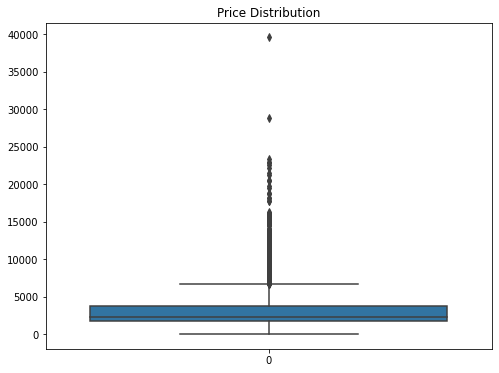

In [14]:

plt.figure(figsize=(8,6))
sns.boxplot(data=train['total_households'])
plt.title('Price Distribution')
plt.show()

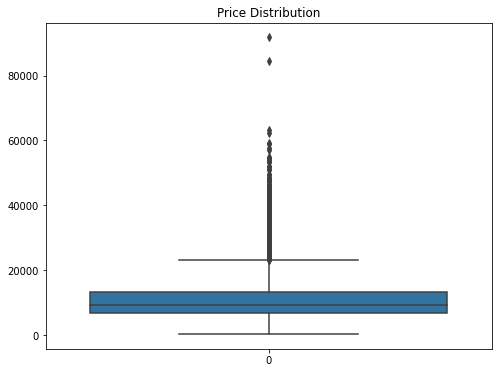

In [15]:

plt.figure(figsize=(8,6))
sns.boxplot(data=train['total_individuals'])
plt.title('Price Distribution')
plt.show()

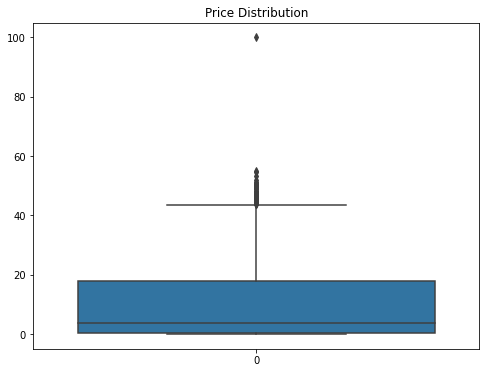

In [16]:
plt.figure(figsize=(8,6))
sns.boxplot(data=train['target_pct_vunerable'])
plt.title('Price Distribution')
plt.show()

# Feature engineering

In [17]:
## classification par kmeans
train_copy=train.copy()
columns=train_copy.drop(["target_pct_vunerable"],1).columns
train_copy=train_copy[columns]
km=KMeans(7,random_state=42)
km=km.fit(train_copy[columns])
train["cluster"]=km.predict(train[columns])
test["cluster"]=km.predict(test[columns])

In [18]:
## suprimer les outlier.
train = train[train['total_households']<=17500]
train = train[train.index!=1094]

In [19]:
train['total_householdslessthan5000'] = train['total_households'].apply(lambda x:1 if 2500<x<=5000  else 0)
test['total_householdslessthan5000'] = test['total_households'].apply(lambda x:1 if 2500<x<=5000  else 0)

In [20]:
train['nmbr_indv_men'] = (train['total_individuals']/train['total_households'])
test['nmbr_indv_men'] = (test['total_individuals']/test['total_households'])
train['Lux'] = train['car_01']+train['stv_00']+train['psa_01']
train['Lux'] = train['car_00'] +train['stv_01']+train['psa_00']
test['Lux'] = test['car_01']+test['stv_00']+test['psa_01']
test['Lux'] = test['car_00'] +test['stv_01']+test['psa_00']
train['No_scool'] = train['psa_01'] + train['psa_02']+ train['psa_03']
test['No_scool'] = test['psa_01'] + test['psa_02']+ test['psa_03']
train['Informal'] = train['dw_02'] + train['dw_07'] + train['dw_06']
test['Informal'] = test['dw_02'] + test['dw_07'] + test['dw_06']
train['total_households']/=train['total_households'].max()
train['total_individuals']/=train['total_individuals'].max()
test['total_households']/=test['total_households'].max()
test['total_individuals']/=test['total_individuals'].max()

In [21]:
train = train.drop(['psa_00','psa_02','psa_03','psa_04','psa_01','lgt_00','stv_01','car_01','lln_01'], axis=1)
test = test.drop(['psa_00','psa_02','psa_03','psa_04','psa_01','lgt_00','stv_01','car_01','lln_01'], axis=1)

In [22]:
#train.head(5)

In [23]:
#test

In [24]:
train['target_pct_vunerable'].max()

54.82847515

# Model

In [25]:
X = train.drop(columns='target_pct_vunerable')
y = train['target_pct_vunerable']

In [26]:
X.shape, test.shape

((3154, 41), (1102, 41))

In [27]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [28]:
from xgboost import XGBRegressor

In [29]:
xgb1 = XGBRegressor()
parameters = {#'nthread':[4], ##uncomment if running on gpu
              'objective':['reg:squarederror'],
              'learning_rate': [.03, 0.05, .07, 0.08, 0.09, 0.1, 0.5 ],
              'max_depth': [5, 6, 7, 8, 9, 10],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500, 1000, 200, 300, 400, 700]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        #n_jobs = 3, ##uncomment if running on gpu 
                        verbose=True)

xgb_grid.fit(X, y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 3 folds for each of 252 candidates, totalling 756 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 756 out of 756 | elapsed: 63.9min finished


0.7959331524682489
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 1000, 'objective': 'reg:squarederror', 'silent': 1, 'subsample': 0.7}


In [30]:
y_pred = xgb_grid.predict(test)

In [31]:
y_pred

array([10.287239 , 31.745535 ,  6.0356946, ...,  4.419676 ,  1.452024 ,
        0.9714205], dtype=float32)

In [32]:
y_pred

array([10.287239 , 31.745535 ,  6.0356946, ...,  4.419676 ,  1.452024 ,
        0.9714205], dtype=float32)

In [33]:
# making submissions
submission_df = pd.DataFrame({'ward': test_ward, 'target_pct_vunerable ': y_pred}) # Creating a submission file



In [34]:
submission_df.to_csv('submit-231_a_1.csv', index=False)